In [1]:
# !git clone https://www.github.com/dmc27/ai2023.git

# **Task 1. Distance-based color segmentation of the red flower**
## **1. Importing libraries**

In [1]:
# import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ai2023.imutils import imshow
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from scipy.sparse import issparse
from tqdm import tqdm

## **2. Reading the original, cropped image, and segmented area and converting it to RGB, HSV, and LAB**

In [2]:
img_rgb = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2RGB)
img_rgb_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2RGB)

img_hsv = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2HSV)
img_hsv_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2HSV)

img_lab = cv2.cvtColor(cv2.imread('ai2023/1600.png'), cv2.COLOR_BGR2LAB)
img_lab_crop = cv2.cvtColor(cv2.imread('ai2023/1600.crop.png'), cv2.COLOR_BGR2LAB)

segmented_area  = cv2.imread('ai2023/segmented_area.png', cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Cropped Image')

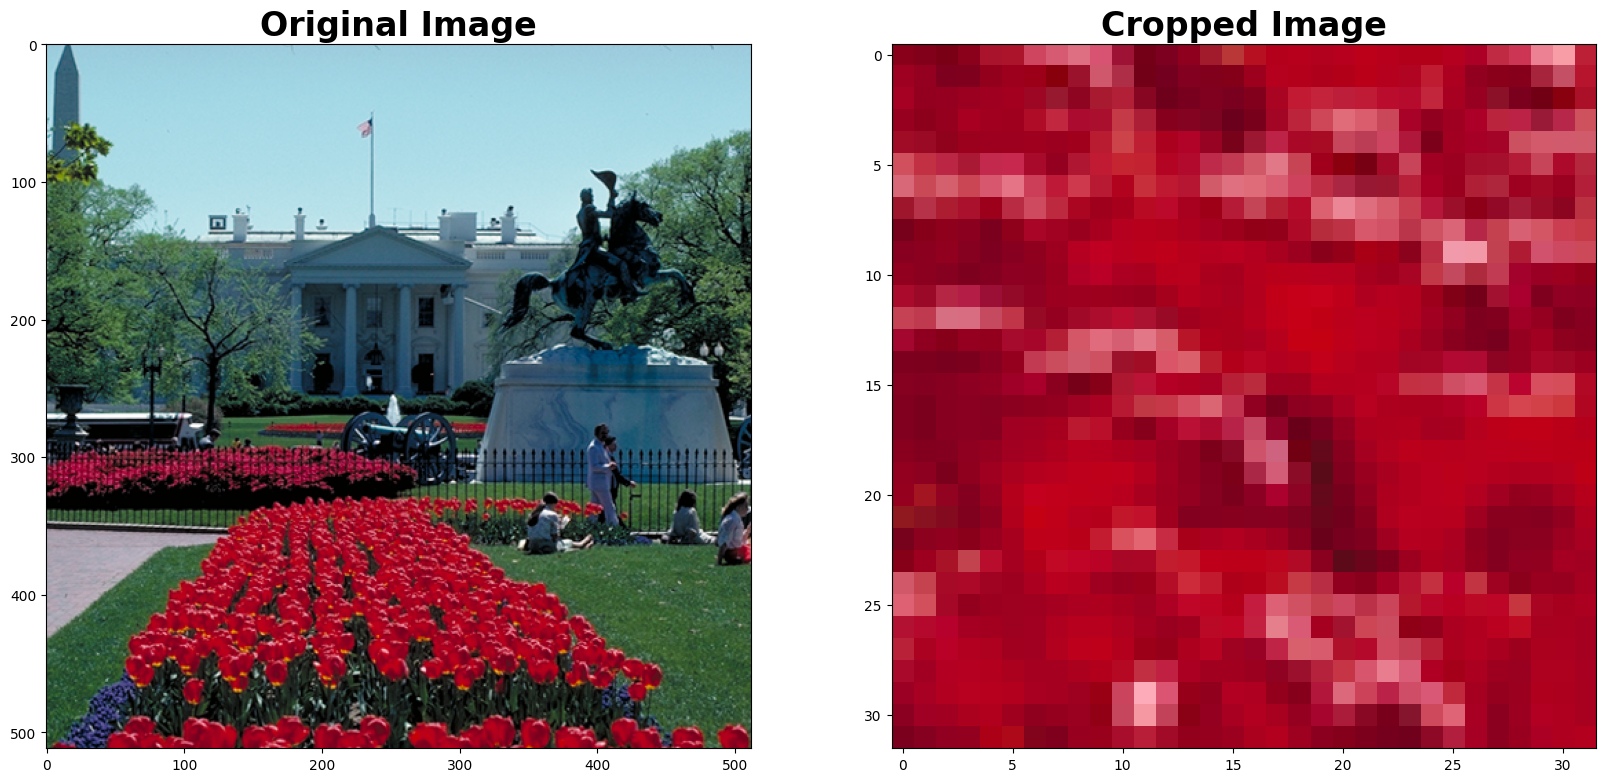

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 12])

ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize = 24, fontweight = 'bold')

ax2.imshow(img_rgb_crop)
ax2.set_title('Cropped Image', fontsize = 24, fontweight = 'bold')

## **3. Experimentation**

## **Exploratory Analysis (RGB)**

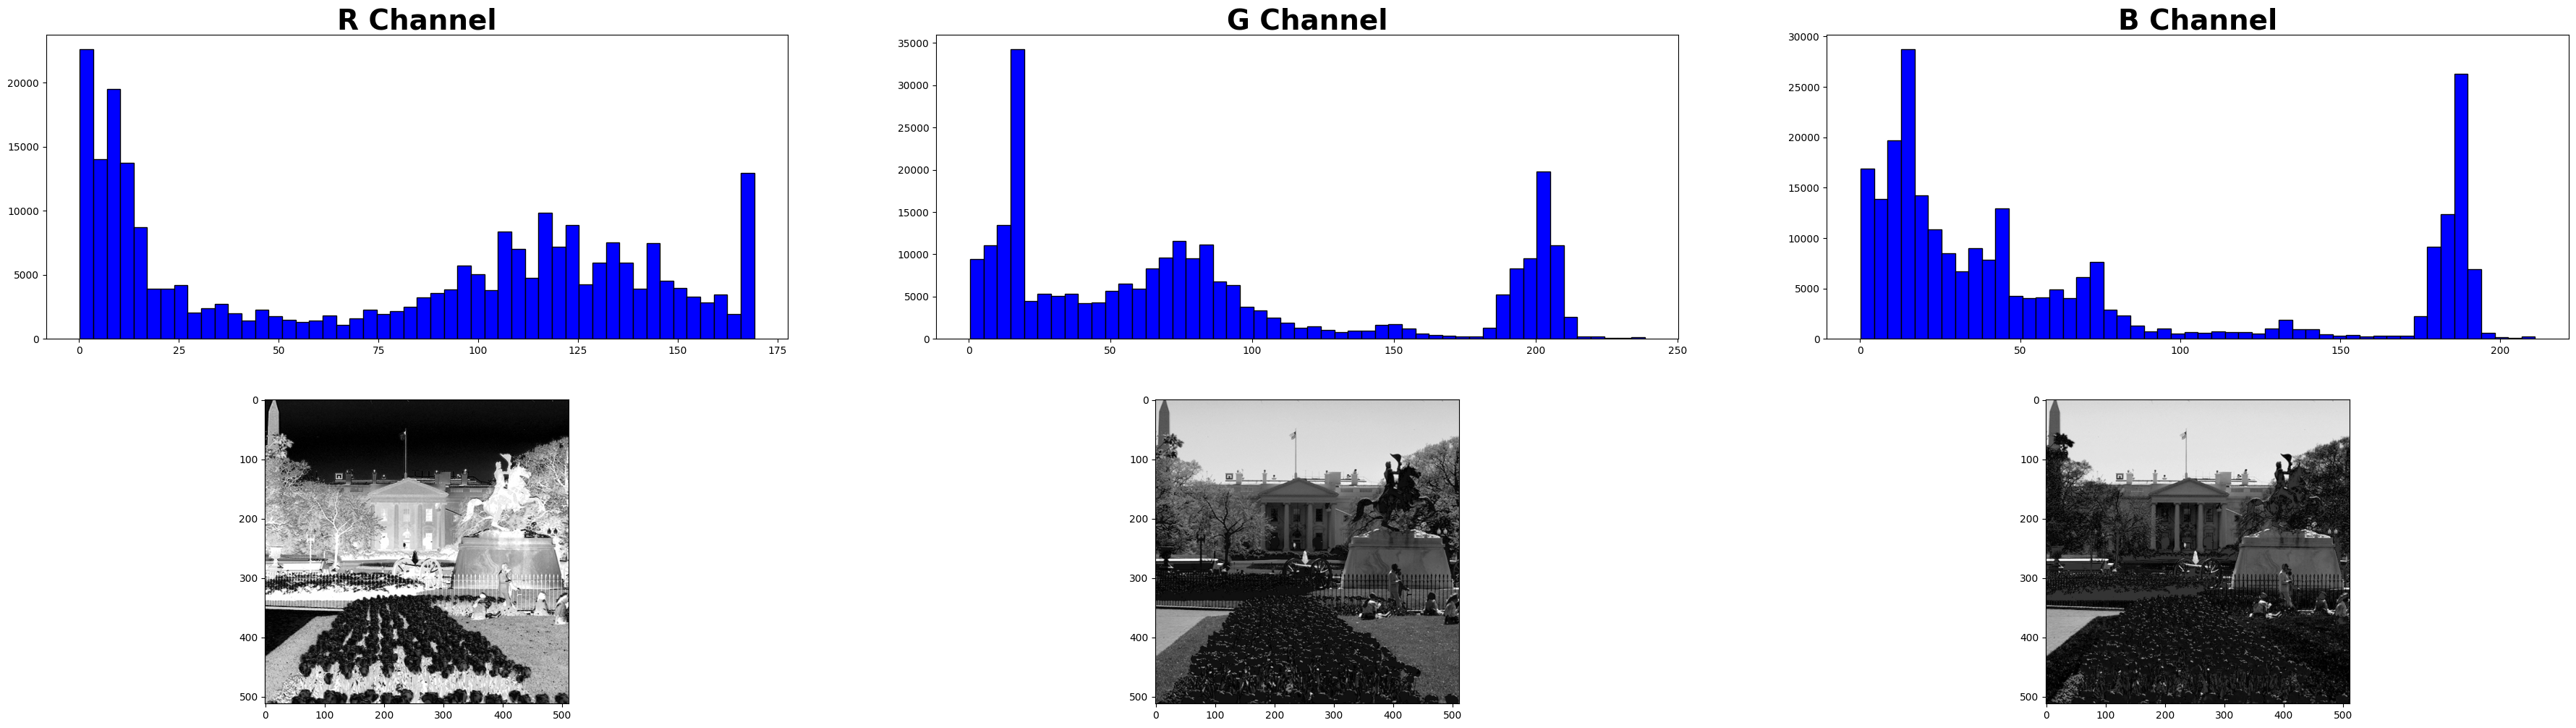

In [4]:
avg_rgb = np.mean(img_rgb_crop, axis = (0, 1))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = [45, 12])
ax1.hist(abs(img_rgb[:, :, 0].astype(np.float64).ravel() - avg_rgb[0]), bins = 50, edgecolor = 'black', color = 'b')
ax1.set_title('R Channel', fontsize = 28, fontweight = 'bold')

ax2.hist(abs(img_rgb[:, :, 1].ravel() - avg_rgb[1]), bins = 50, edgecolor = 'black', color = 'b')
ax2.set_title('G Channel', fontsize = 28, fontweight = 'bold')

ax3.hist(abs(img_rgb[:, :, 2].ravel() - avg_rgb[2]), bins = 50, edgecolor = 'black', color = 'b')
ax3.set_title('B Channel', fontsize = 28, fontweight = 'bold')

ax4.imshow((abs(img_rgb[:, :, 0].ravel() - avg_rgb[0])).reshape(512, 512), cmap = 'gray')
ax5.imshow((abs(img_rgb[:, :, 1].ravel() - avg_rgb[1])).reshape(512, 512), cmap = 'gray')
ax6.imshow((abs(img_rgb[:, :, 2].ravel() - avg_rgb[2])).reshape(512, 512), cmap = 'gray')

<font size="5.5"> 
The histograms shown in the figure above are the absolute difference or distance between the original "1600.png" image and the cropped image in RGB color space. The cropped image contains a small portion of the original image's red flower (rose). The absolute difference or distance for RGB color space is defined as
</font>

$$\partial_R = abs\left(I[R] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[R]_i\right)\right)$$
$$\partial_G = abs\left(I[G] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[G]_i\right)\right)$$
$$\partial_B = abs\left(I[B] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[B]_i\right)\right)$$

<font size="5.5"> 
By displaying the absolute distance for each image channel, the distance value distribution can be observed. Beginning with the first histogram (red channel), two distributions are evident (bimodal distribution). There are at least three distributions in the second histogram (green channel) (trimodal distribution). For the final histogram (blue channel), at least two distributions are present. This statistically indicates that multiple classes are present in the image. The graph depicts the absolute distance between the original image and the cropped image for each channel. In addition, the figure displayed below the histogram demonstrates that in the RGB color space, the red channel is the primary characteristic for segmenting the red flower. However, the green and blue channels also play a role in the process of segmentation. The black pixel in the image represents the closeness or similarity between the original image and the image we wish to segment.
</font>

In [5]:
print(np.std(img_rgb_crop[:, :, 0]))
print(np.std(img_rgb_crop[:, :, 1]))
print(np.std(img_rgb_crop[:, :, 2]))

26.03328860796393
30.160438792201326
26.42712682214952


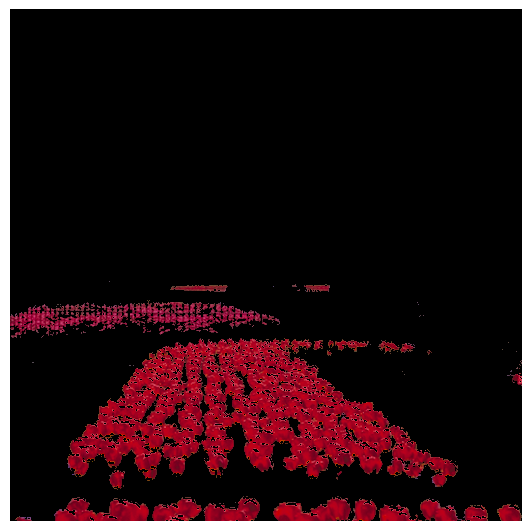

In [6]:
# Calculating the absolute distance
absolute_distance_rgb = abs(img_rgb.astype(np.float64) - np.mean(img_rgb_crop, axis = (0, 1)))
std_crop_rgb = np.std(img_rgb_crop, axis = (0, 1))
segmented_img_rgb = img_rgb * (absolute_distance_rgb[:, :,0][:,:, np.newaxis] < 3.265 * std_crop_rgb[0]) * (absolute_distance_rgb[:, :, 1][:,:, np.newaxis] < 1.9893 * std_crop_rgb[1]) * (absolute_distance_rgb[:, :, 2][:,:, np.newaxis] < 4.5408 * std_crop_rgb[2])
imshow(segmented_img_rgb, zoom = 1)

Text(0.5, 1.0, 'Area to be segmented\n(Manual image annotation)')

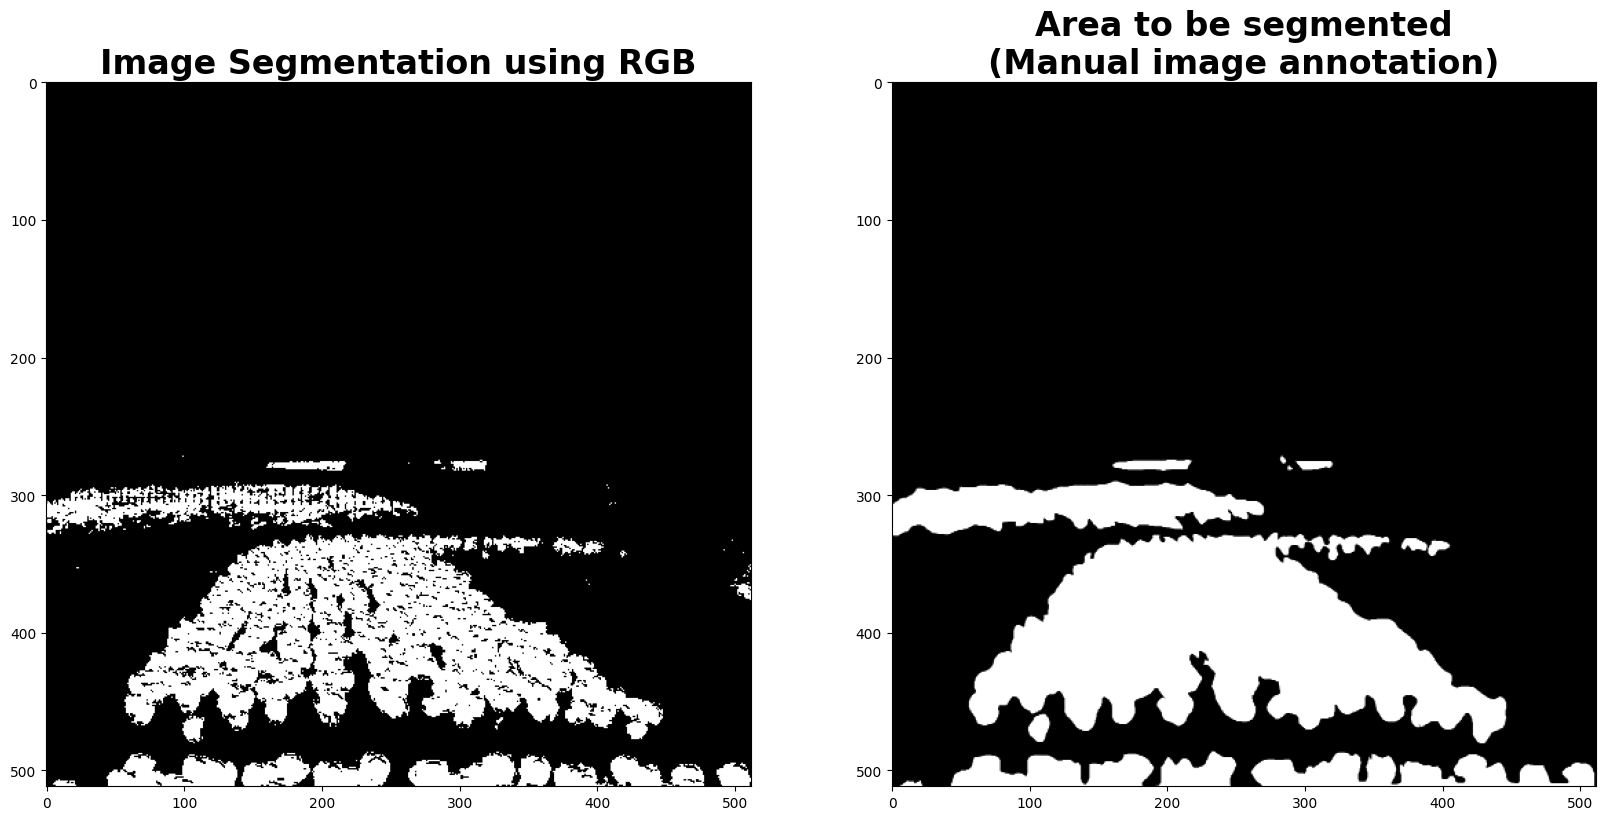

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 12])

ax1.imshow(segmented_img_rgb[:, :, 0].astype(np.bool_) | segmented_img_rgb[:, :, 1].astype(np.bool_) | segmented_img_rgb[:, :, 2].astype(np.bool_) * 255, cmap = 'gray')
ax1.set_title('Image Segmentation using RGB', fontsize = 24, fontweight = 'bold')

ax2.imshow(segmented_area, cmap = 'gray')
ax2.set_title('Area to be segmented\n(Manual image annotation)', fontsize = 24, fontweight = 'bold')
# imshow(segmented_img_rgb[:, :, 0].astype(np.bool_) | segmented_img_rgb[:, :, 1].astype(np.bool_) | segmented_img_rgb[:, :, 2].astype(np.bool_) * 255)
# imshow(segmented_area)

## **Exploratory Analysis (HSV)**

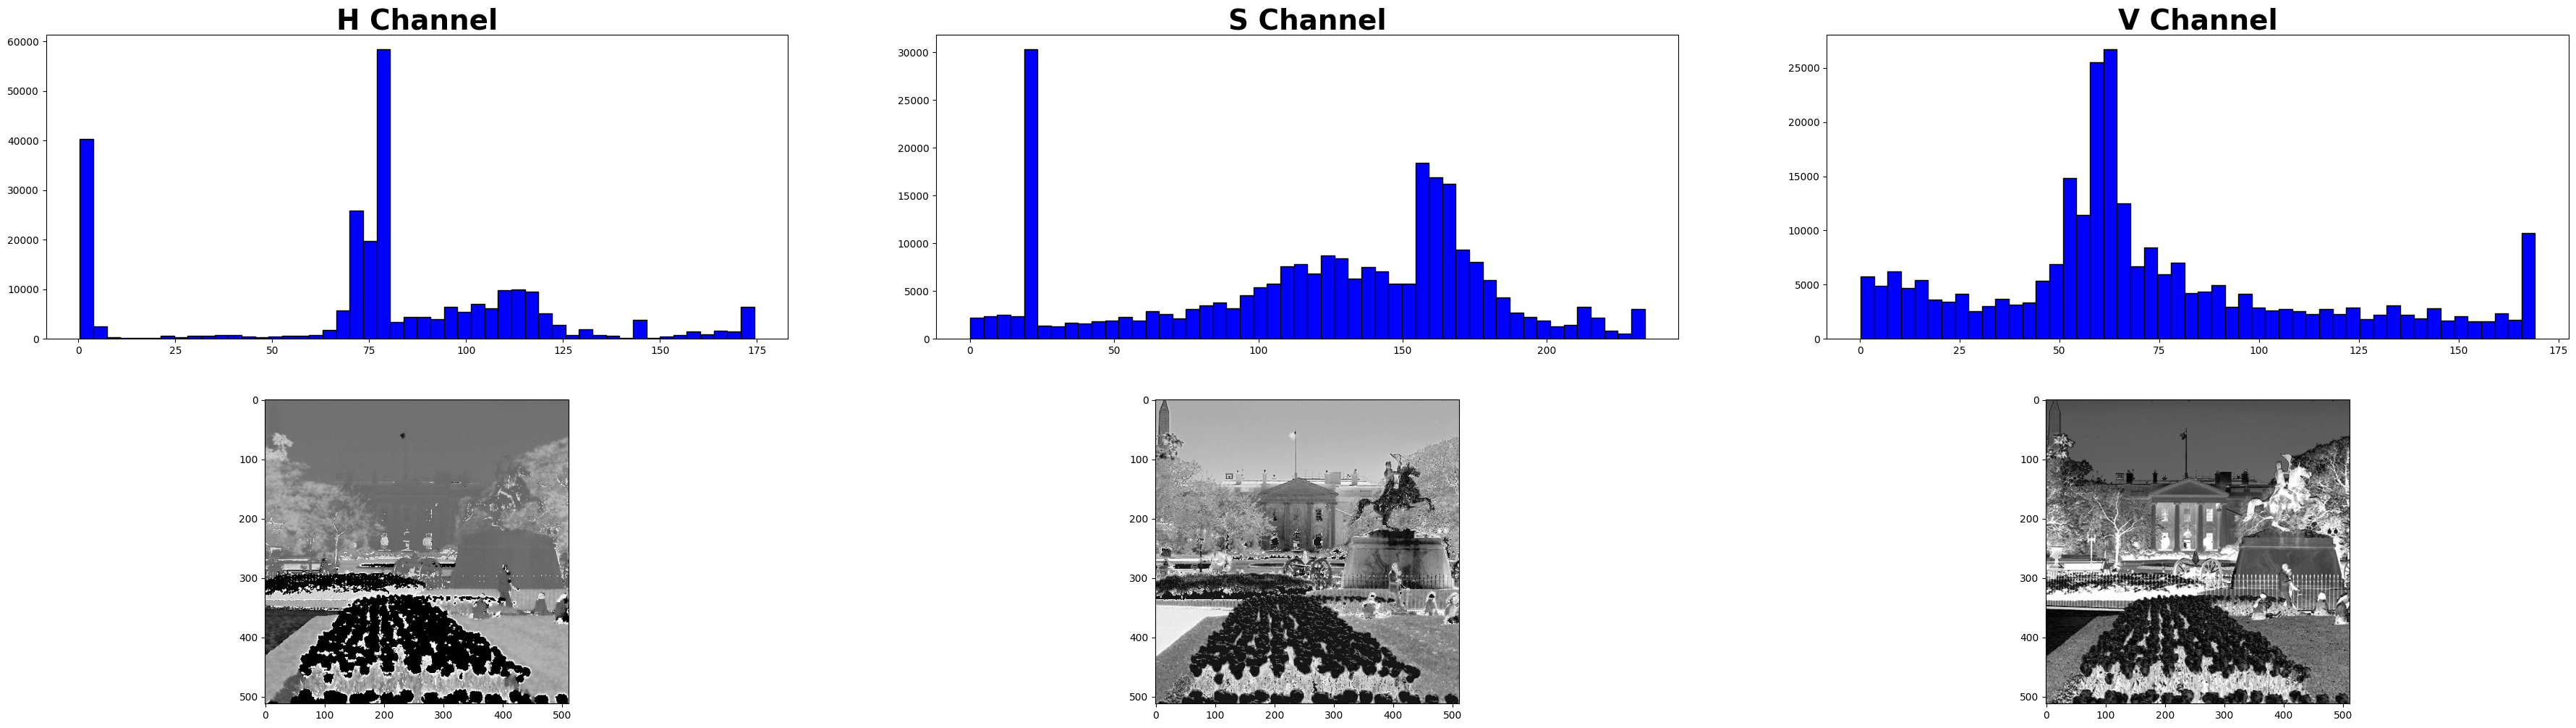

In [8]:
avg_hsv = np.mean(img_hsv_crop, axis = (0, 1))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = [45, 12])
ax1.hist(abs(img_hsv[:, :, 0].astype(np.float64).ravel() - avg_hsv[0]), bins = 50, edgecolor = 'black', color = 'b')
ax1.set_title('H Channel', fontsize = 28, fontweight = 'bold')

ax2.hist(abs(img_hsv[:, :, 1].ravel() - avg_hsv[1]), bins = 50, edgecolor = 'black', color = 'b')
ax2.set_title('S Channel', fontsize = 28, fontweight = 'bold')

ax3.hist(abs(img_hsv[:, :, 2].ravel() - avg_hsv[2]), bins = 50, edgecolor = 'black', color = 'b')
ax3.set_title('V Channel', fontsize = 28, fontweight = 'bold')

distance_img_hsv = abs(img_hsv.astype(np.float64) - avg_hsv)

ax4.imshow(distance_img_hsv[:, :, 0], cmap = 'gray')
ax5.imshow(distance_img_hsv[:, :, 1], cmap = 'gray')
ax6.imshow(distance_img_hsv[:, :, 2], cmap = 'gray')

<font size="5.5"> 
The histograms shown in the figure above are the absolute difference or distance between the original "1600.png" image and the cropped image in HSV color space. The absolute difference or distance for HSV color space is defined as
</font>

$$\partial_H = abs\left(I[H] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[H]_i\right)\right)$$
$$\partial_S = abs\left(I[S] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[S]_i\right)\right)$$
$$\partial_V = abs\left(I[V] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[V]_i\right)\right)$$

<font size="5.5"> 
By displaying the absolute distance for each image channel, the distance value distribution can be observed. Beginning with the first histogram (Hue channel), three distributions are evident (trimodal distribution). There are at least three distributions in the second histogram (Saturation channel). For the final histogram (Value channel), at least three distributions are present. This statistically indicates that multiple classes are present in the image. In addition, the figure displayed below the histogram demonstrates that in the HSV color space, the Hue channel is the primary characteristic for segmenting the red flower. However, the Saturation and Value channels also play a role in the process of segmentation.
</font>

In [9]:
print(np.std(img_hsv_crop[:, :, 0]))
print(np.std(img_hsv_crop[:, :, 1]))
print(np.std(img_hsv_crop[:, :, 2]))

5.576478004403294
36.131418892043854
26.03328860796393


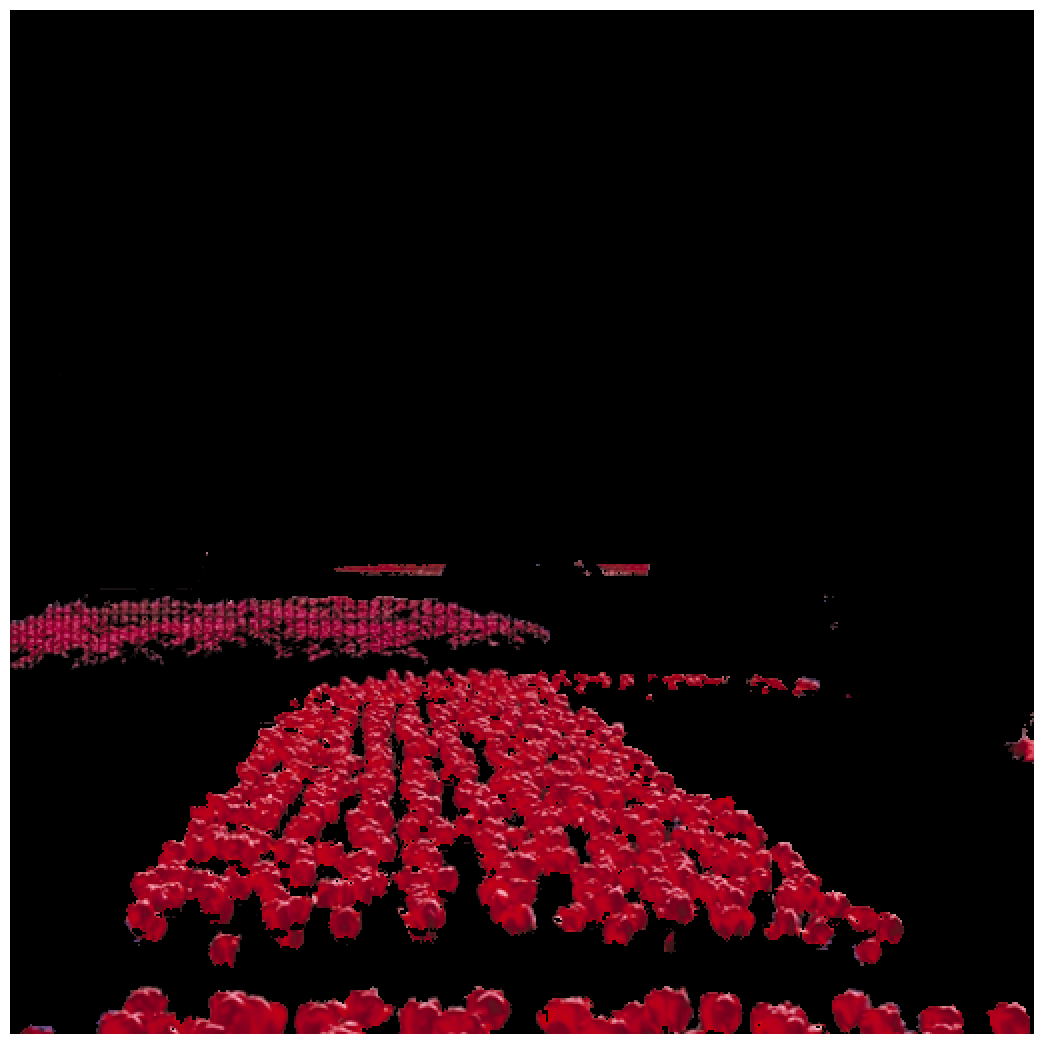

In [10]:
# Calculating the absolute distance
absolute_distance_hsv = abs(img_hsv.astype(np.float64) - np.mean(img_hsv_crop, axis = (0, 1)))
std_crop_hsv = np.std(img_hsv_crop, axis = (0, 1))
segmented_img_hsv = img_hsv * (absolute_distance_hsv[:, :,0][:,:, np.newaxis] < 7.8975 * std_crop_hsv[0]) * (absolute_distance_hsv[:, :, 1][:,:, np.newaxis] < 4.49895 * std_crop_hsv[1]) * (absolute_distance_hsv[:, :, 2][:,:, np.newaxis] < 7.49867 * std_crop_hsv[2])
imshow(cv2.cvtColor(segmented_img_hsv, cv2.COLOR_HSV2RGB), zoom = 2)

Text(0.5, 1.0, 'Area to be segmented\n(Manual image annotation)')

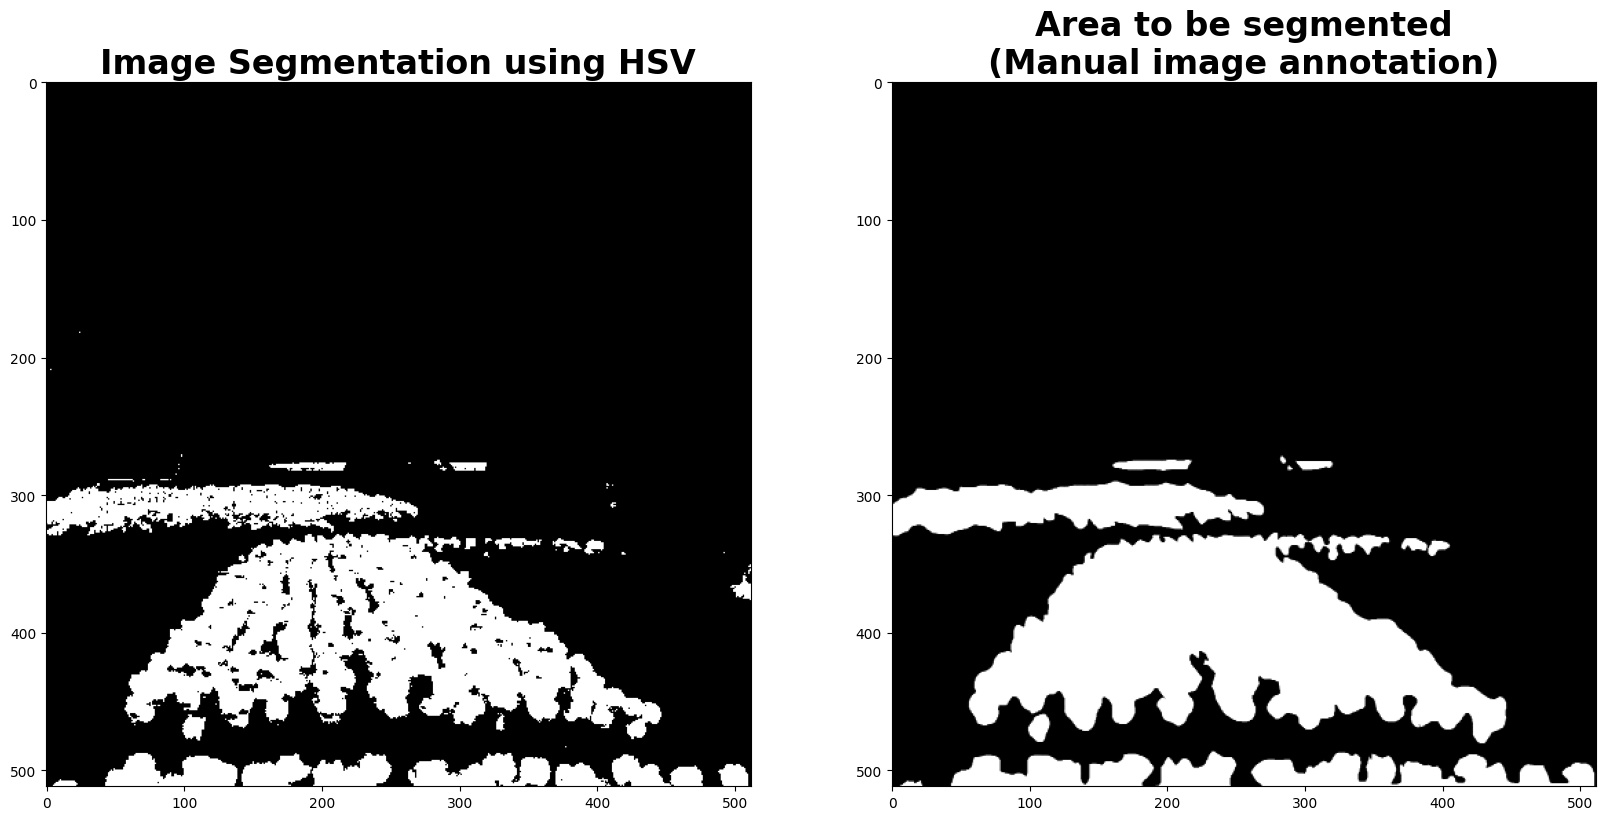

In [11]:
segmented_hsv_to_rgb = cv2.cvtColor(segmented_img_hsv, cv2.COLOR_HSV2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 12])

ax1.imshow(segmented_hsv_to_rgb[:, :, 0].astype(np.bool_) | segmented_hsv_to_rgb[:, :, 1].astype(np.bool_) | segmented_hsv_to_rgb[:, :, 2].astype(np.bool_) * 255, cmap = 'gray')
ax1.set_title('Image Segmentation using HSV', fontsize = 24, fontweight = 'bold')

ax2.imshow(segmented_area, cmap = 'gray')
ax2.set_title('Area to be segmented\n(Manual image annotation)', fontsize = 24, fontweight = 'bold')
# imshow(segmented_img_rgb[:, :, 0].astype(np.bool_) | segmented_img_rgb[:, :, 1].astype(np.bool_) | segmented_img_rgb[:, :, 2].astype(np.bool_) * 255)
# imshow(segmented_area)

## **Exploratory Analysis (LAB)**

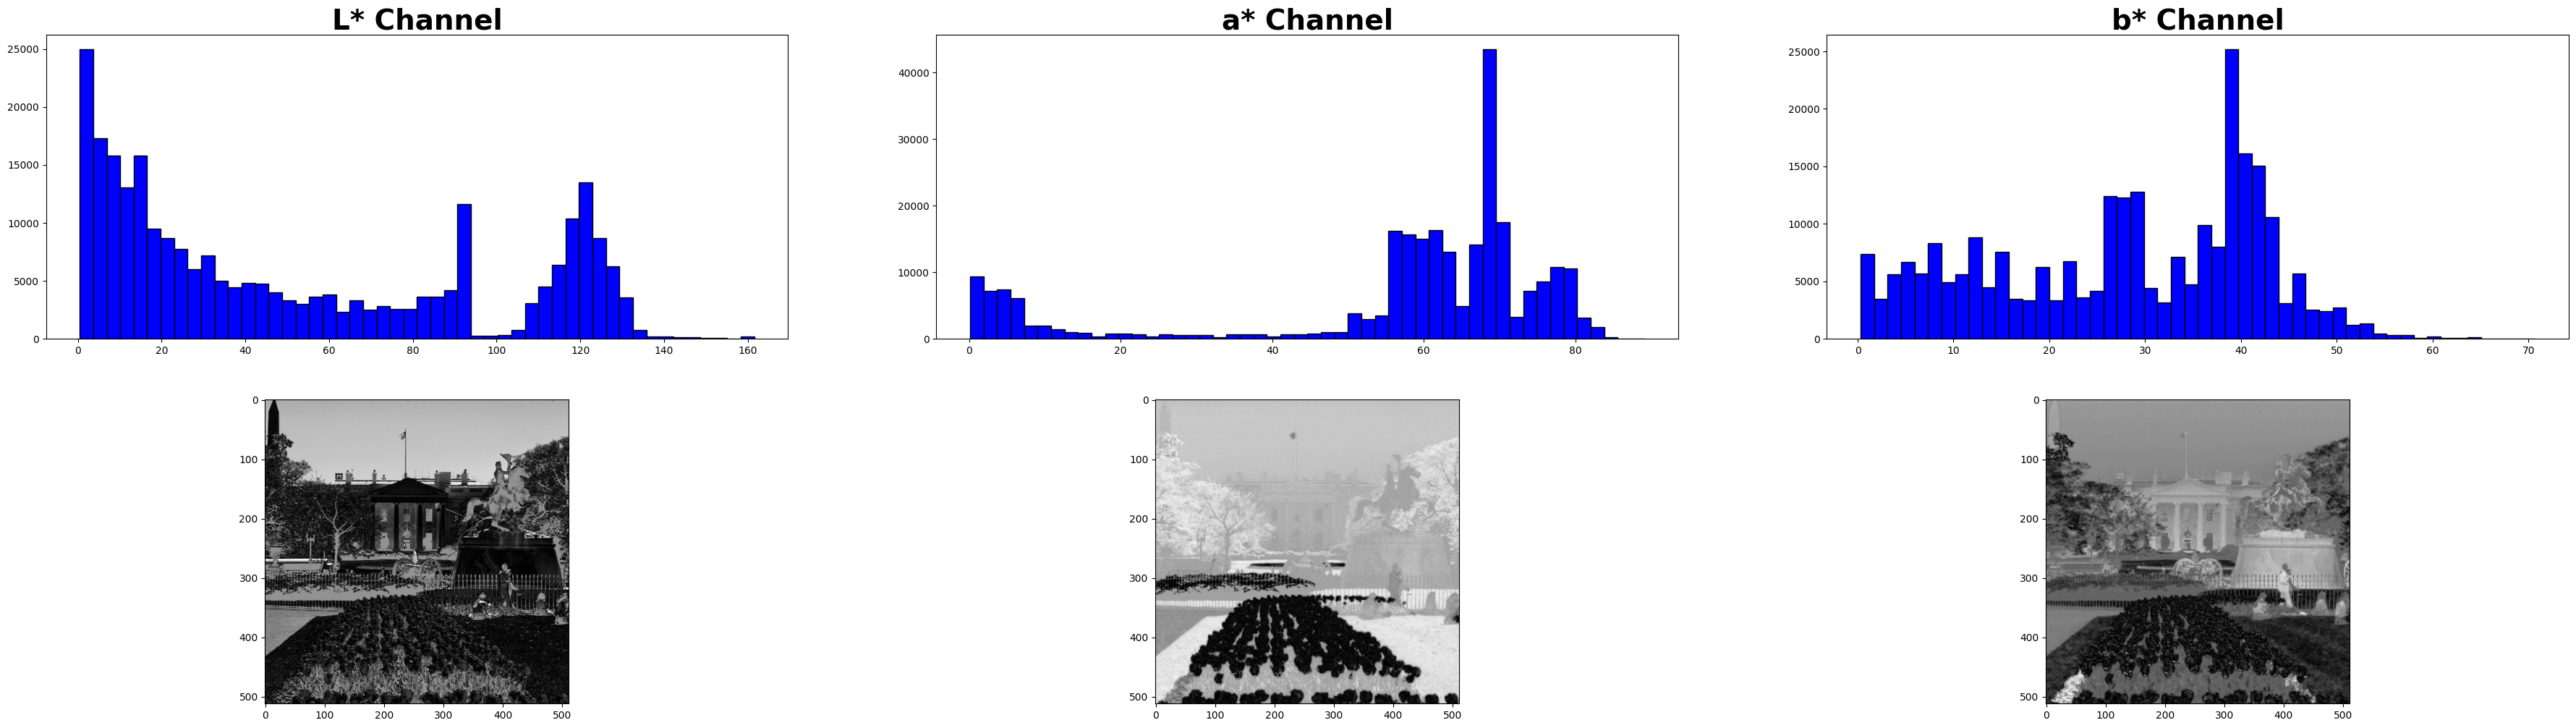

In [12]:
avg_lab = np.mean(img_lab_crop, axis = (0, 1))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = [45, 12])
ax1.hist(abs(img_lab[:, :, 0].astype(np.float64).ravel() - avg_lab[0]), bins = 50, edgecolor = 'black', color = 'b')
ax1.set_title('L* Channel', fontsize = 28, fontweight = 'bold')

ax2.hist(abs(img_lab[:, :, 1].ravel() - avg_lab[1]), bins = 50, edgecolor = 'black', color = 'b')
ax2.set_title('a* Channel', fontsize = 28, fontweight = 'bold')

ax3.hist(abs(img_lab[:, :, 2].ravel() - avg_lab[2]), bins = 50, edgecolor = 'black', color = 'b')
ax3.set_title('b* Channel', fontsize = 28, fontweight = 'bold')

distance_img_lab = abs(img_lab.astype(np.float64) - avg_lab)

ax4.imshow(distance_img_lab[:, :, 0], cmap = 'gray')
ax5.imshow(distance_img_lab[:, :, 1], cmap = 'gray')
ax6.imshow(distance_img_lab[:, :, 2], cmap = 'gray')

<font size="5.5"> 
The histograms shown in the figure above are the absolute difference or distance between the original "1600.png" image and the cropped image in LAB color space. The absolute difference or distance for LAB color space is defined as
</font>

$$\partial_L^* = abs\left(I[L^*] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[L^*]_i\right)\right)$$
$$\partial_a^* = abs\left(I[a^*] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[a^*]_i\right)\right)$$
$$\partial_b^* = abs\left(I[b^*] - \left(\frac{1}{N}\sum_{i = 1}^{N}I[b^*]_i\right)\right)$$

<font size="5.5">

By displaying the absolute distance for each image channel, the distance value distribution can be observed. Beginning with the first histogram (L* channel), two distributions are evident (bimodal distribution). For the second histogram (a* channel), two distributions are also present in the image. However, For the final histogram (b* channel), we cannot determine how many distribution in the channel because the distance for each distributions are significantly small. This statistically indicates that multiple classes are present in the image. In addition, the figure displayed below the histogram demonstrates that in the LAB color space, the a* channel is the primary characteristic for segmenting the red flower. Besides, the L* and b* channels also play a role in the process of segmentation.
</font>

In [13]:
print(np.std(img_lab_crop[:, :, 0]))
print(np.std(img_lab_crop[:, :, 1]))
print(np.std(img_lab_crop[:, :, 2]))

21.56191750444533
5.6171844439969085
8.1213308999728


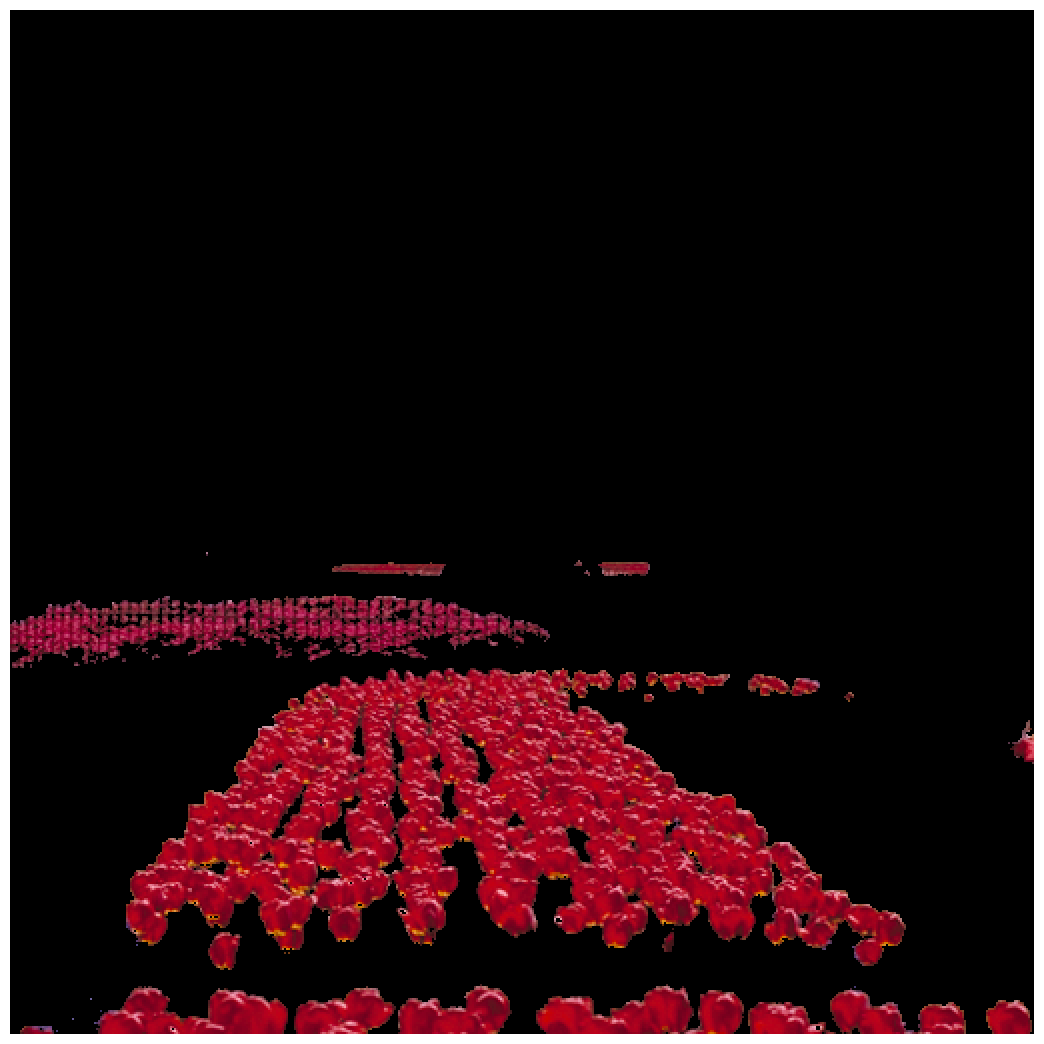

In [14]:
# Calculating the absolute distance
absolute_distance_lab = abs(img_lab.astype(np.float64) - np.mean(img_lab_crop, axis = (0, 1)))
std_crop_lab = np.std(img_lab_crop, axis = (0, 1))
segmented_img_lab = img_lab * (absolute_distance_lab[:, :,0][:,:, np.newaxis] < 5 * std_crop_lab[0]) * (absolute_distance_lab[:, :, 1][:,:, np.newaxis] < 6.8 * std_crop_lab[1]) * (absolute_distance_lab[:, :, 2][:,:, np.newaxis] < 7.4 * std_crop_lab[2])
segmented_img_lab[:, :, 1][segmented_img_lab[:, :, 1] == 0] = -128.
segmented_img_lab[:, :, 2][segmented_img_lab[:, :, 2] == 0] = -128.
imshow(cv2.cvtColor(segmented_img_lab, cv2.COLOR_LAB2RGB), zoom = 2)

Text(0.5, 1.0, 'Area to be segmented\n(Manual image annotation)')

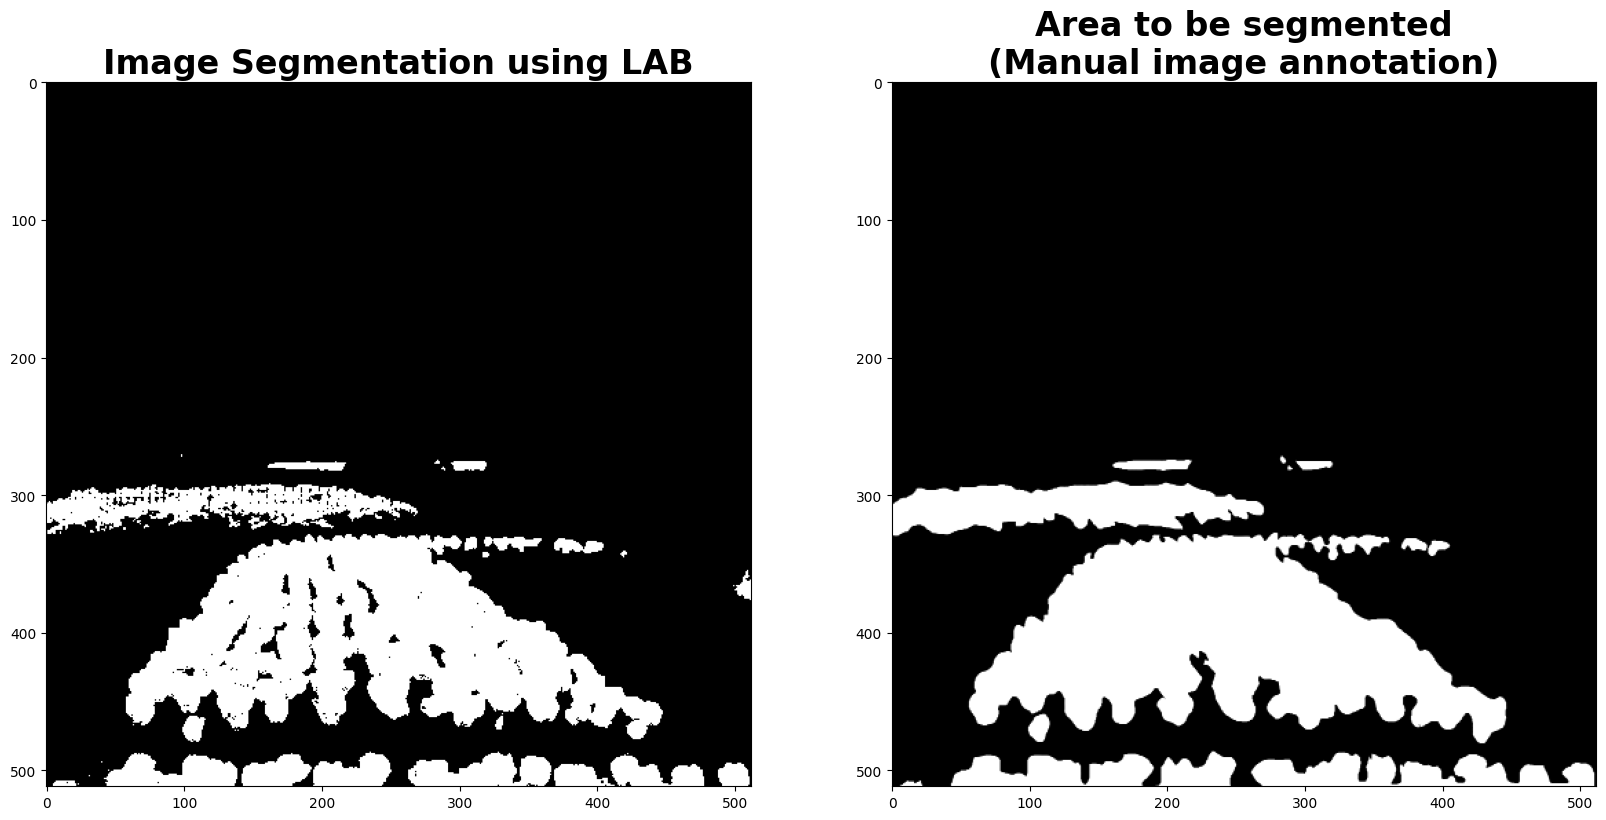

In [15]:
segmented_lab_to_rgb = cv2.cvtColor(segmented_img_lab, cv2.COLOR_LAB2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 12])

ax1.imshow(segmented_lab_to_rgb[:, :, 0].astype(np.bool_) | segmented_lab_to_rgb[:, :, 1].astype(np.bool_) | segmented_lab_to_rgb[:, :, 2].astype(np.bool_) * 255, cmap = 'gray')
ax1.set_title('Image Segmentation using LAB', fontsize = 24, fontweight = 'bold')

ax2.imshow(segmented_area, cmap = 'gray')
ax2.set_title('Area to be segmented\n(Manual image annotation)', fontsize = 24, fontweight = 'bold')
# imshow(segmented_img_rgb[:, :, 0].astype(np.bool_) | segmented_img_rgb[:, :, 1].astype(np.bool_) | segmented_img_rgb[:, :, 2].astype(np.bool_) * 255)
# imshow(segmented_area)

## **4. Results and Discussion**

Text(0.5, 1.0, 'LAB Color Space')

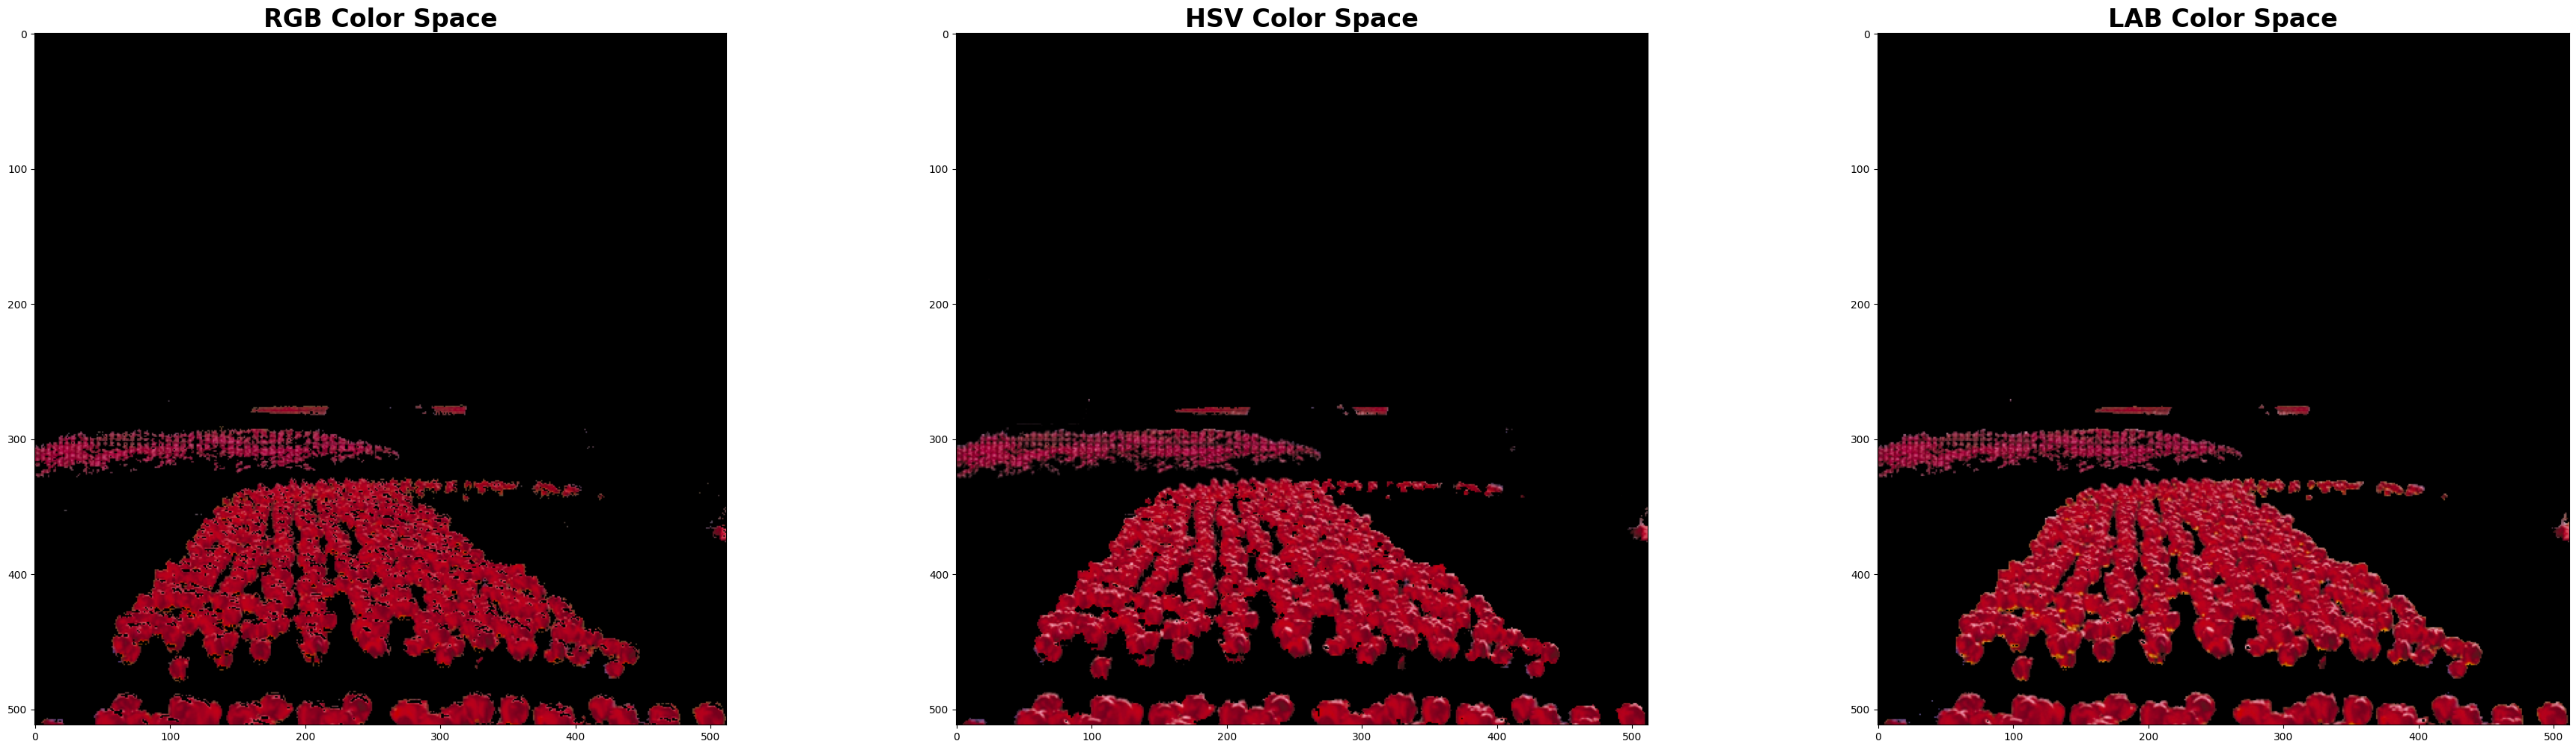

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [45, 12])

ax1.imshow(segmented_img_rgb, cmap = 'gray')
ax1.set_title('RGB Color Space', fontsize = 24, fontweight = 'bold')

ax2.imshow(segmented_hsv_to_rgb, cmap = 'gray')
ax2.set_title('HSV Color Space', fontsize = 24, fontweight = 'bold')

ax3.imshow(segmented_lab_to_rgb, cmap = 'gray')
ax3.set_title('LAB Color Space', fontsize = 24, fontweight = 'bold')

<font size="5.5"> 
The above figure shows the result of red flower segmentation using three color spaces such as RGB, HSV, and LAB based on the absolute distance. Among the three color spaces, RGB color space performs the worst as there are a lot of black spots inside the red flower. This means that there are parts of the flower that is not segmented properly.
</font>

### **Defining function for calculating a simple Mean Intersection over Union (mIoU), Precision, Recall, and F1-score**

In [17]:
def mIoU(image, area):
    temp_calc_bool = image[:, :, 0].astype(np.bool_) | image[:, :, 1].astype(np.bool_) | image[:, :, 2].astype(np.bool_)
    IoU = np.logical_and(temp_calc_bool, area.astype(np.bool_)).sum() / np.logical_or(temp_calc_bool, area.astype(np.bool_)).sum()
    return IoU

def precision_recall_f1(image, area):
    temp_calc_bool = image[:, :, 0].astype(np.bool_) | image[:, :, 1].astype(np.bool_) | image[:, :, 2].astype(np.bool_)
    return classification_report(temp_calc_bool.ravel(), area.astype(np.bool_).ravel())

In [18]:
print("RGB based segmentation")
print('===========================')
print()
print(precision_recall_f1(segmented_img_rgb, segmented_area))
print("HSV based segmentation")
print('===========================')
print()
print(precision_recall_f1(segmented_hsv_to_rgb, segmented_area))
print("LAB based segmentation")
print('===========================')
print()
print(precision_recall_f1(segmented_lab_to_rgb, segmented_area))

RGB based segmentation

              precision    recall  f1-score   support

       False       1.00      0.95      0.97    222575
        True       0.78      0.99      0.87     39569

    accuracy                           0.96    262144
   macro avg       0.89      0.97      0.92    262144
weighted avg       0.96      0.96      0.96    262144

HSV based segmentation

              precision    recall  f1-score   support

       False       1.00      0.96      0.98    219503
        True       0.84      0.98      0.90     42641

    accuracy                           0.97    262144
   macro avg       0.92      0.97      0.94    262144
weighted avg       0.97      0.97      0.97    262144

LAB based segmentation

              precision    recall  f1-score   support

       False       1.00      0.97      0.98    217623
        True       0.88      0.98      0.93     44521

    accuracy                           0.97    262144
   macro avg       0.94      0.98      0.96    262144
we

# **Task 2. k-Means Based Color Segmentation**

In [19]:
img_bgr = cv2.imread('ai2023/1600.png')
img_crop_kmean = cv2.imread('ai2023/1600.crop.png')

img_bgr = img_bgr.astype(np.float32) / 255.
img_crop_kmean = img_crop_kmean.astype(np.float32) / 255.

img_rgb_kmean = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv_kmean = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_lab_kmean = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

img_crop_rgb_kmean = cv2.cvtColor(img_crop_kmean, cv2.COLOR_BGR2RGB)
img_crop_hsv_kmean = cv2.cvtColor(img_crop_kmean, cv2.COLOR_BGR2HSV)
img_crop_lab_kmean = cv2.cvtColor(img_crop_kmean, cv2.COLOR_BGR2LAB)

In [27]:
kmeans = KMeans(n_clusters = 3, n_init = 20)
kmeans.fit(img_rgb_kmean.reshape(-1, 3))
print(kmeans.cluster_centers_)

idx = np.argmin(np.sum(abs(kmeans.cluster_centers_ - np.mean(img_crop_rgb_kmean, axis = (0, 1))), axis = 1))
cluster_center = np.zeros(kmeans.cluster_centers_.shape)
cluster_center[idx] = kmeans.cluster_centers_[idx]

seg_rgb_vals = cluster_center[kmeans.labels_]

seg_rgb_img = seg_rgb_vals.reshape(img_rgb_kmean.shape)
# imshow(seg_rgb_img)

[[0.65735126 0.8168415  0.8624995 ]
 [0.6200559  0.07868603 0.16833766]
 [0.17973027 0.26941285 0.24888279]]


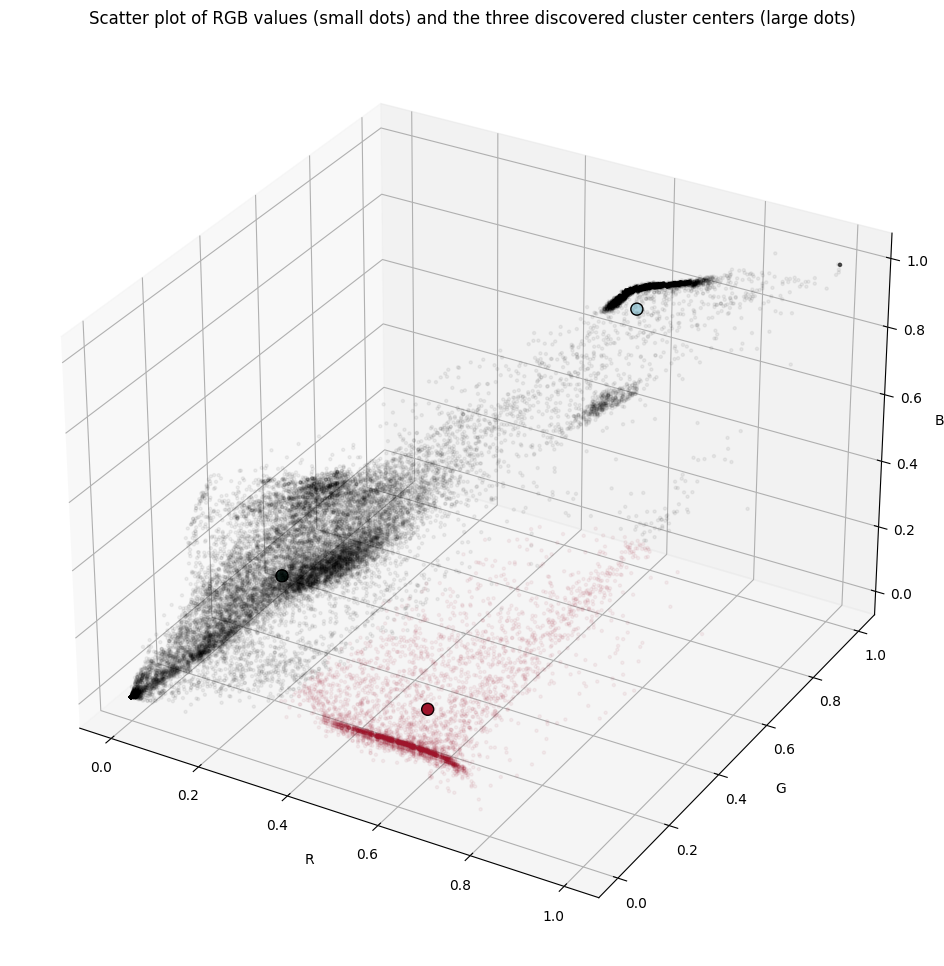

In [30]:
# Figure initialization
fig_size = 12
fig = plt.figure(figsize=(fig_size, fig_size))
ax = fig.add_subplot(111, projection="3d")

# Create scatter plot
ax.scatter(img_rgb_kmean.reshape(-1, 3)[::10, 0], img_rgb_kmean.reshape(-1, 3)[::10, 1], 
  img_rgb_kmean.reshape(-1, 3)[::10, 2], c=seg_rgb_vals[::10], s=5, alpha=0.05)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
  kmeans.cluster_centers_[:, 2], c=kmeans.cluster_centers_, s=75, marker="o", 
  edgecolors=[(0, 0, 0)], alpha=1)

# labels and title
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.title("Scatter plot of RGB values (small dots) and the three discovered cluster centers (large dots)")

plt.show()

In [37]:
kmeans = KMeans(n_clusters = 3, n_init = 20)
kmeans.fit(img_hsv_kmean.reshape(-1, 3))

idx = np.argmin(np.sum(abs(kmeans.cluster_centers_ - np.mean(img_crop_hsv_kmean, axis = (0, 1))), axis = 1))
cluster_center = np.zeros(kmeans.cluster_centers_.shape)
cluster_center[idx] = kmeans.cluster_centers_[idx]

seg_hsv_vals = cluster_center[kmeans.labels_]

seg_hsv_img = seg_hsv_vals.reshape(img_hsv_kmean.shape)

# imshow(cv2.cvtColor(seg_hsv_img.astype(np.float32), cv2.COLOR_HSV2RGB))

In [39]:
kmeans.cluster_centers_

array([[3.4369458e+02, 7.9921424e-01, 5.9270662e-01],
       [9.5719009e+01, 4.2609188e-01, 2.9635066e-01],
       [1.9124596e+02, 3.8069957e-01, 5.6970519e-01]], dtype=float32)

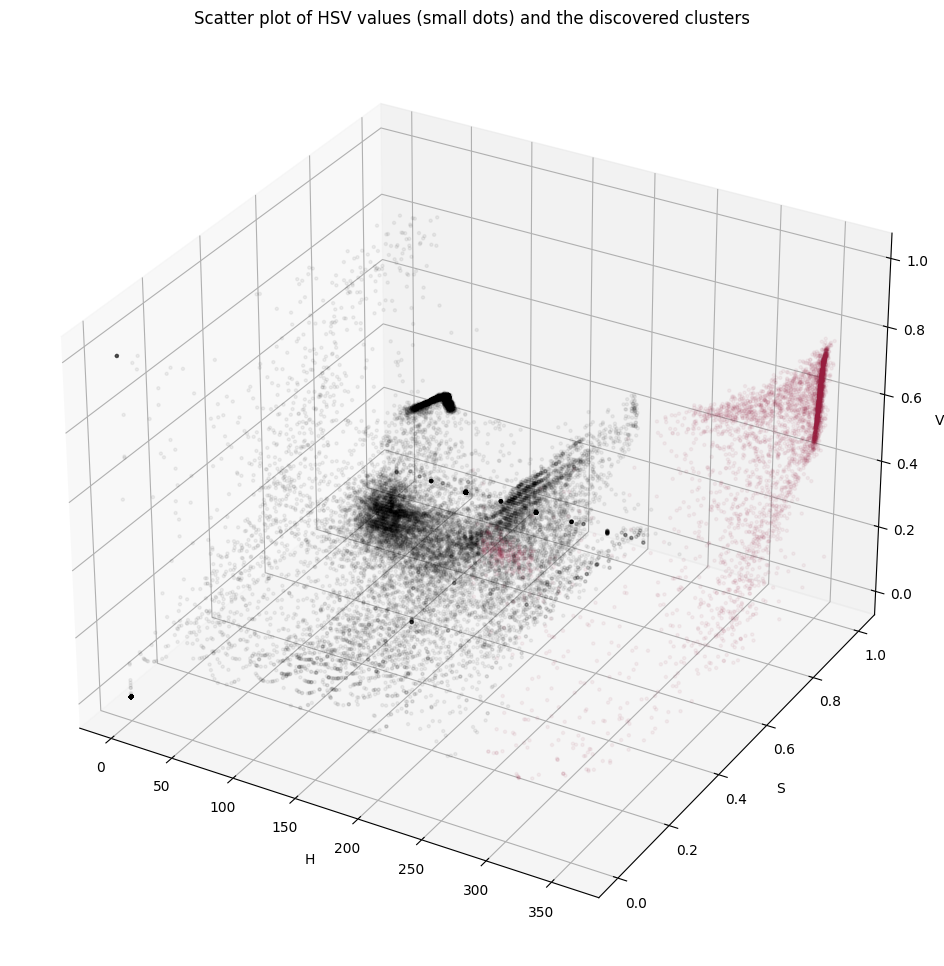

In [46]:
# Figure initialization
fig_size = 12
fig = plt.figure(figsize=(fig_size, fig_size))
ax = fig.add_subplot(111, projection="3d")

# Create scatter plot
seg_hsv_val_plot = cv2.cvtColor(seg_hsv_img.astype(np.float32), cv2.COLOR_HSV2RGB).reshape(-1, 3)
ax.scatter(img_hsv_kmean.reshape(-1, 3)[::10, 0], img_hsv_kmean.reshape(-1, 3)[::10, 1], 
  img_hsv_kmean.reshape(-1, 3)[::10, 2], c=seg_hsv_val_plot[::10], s=5, alpha=0.05)
# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
#   kmeans.cluster_centers_[:, 2], c=kmeans.cluster_centers_, s=75, marker="o", 
#   edgecolors=[(0, 0, 0)], alpha=1)

# labels and title
ax.set_xlabel("H")
ax.set_ylabel("S")
ax.set_zlabel("V")
plt.title("Scatter plot of HSV values (small dots) and the discovered clusters")

plt.show()

In [43]:
kmeans = KMeans(n_clusters = 3, n_init = 20)
kmeans.fit(img_lab_kmean.reshape(-1, 3))

idx = np.argmin(np.sum(abs(kmeans.cluster_centers_ - np.mean(img_crop_lab_kmean, axis = (0, 1))), axis = 1))
cluster_center = np.zeros(kmeans.cluster_centers_.shape)
cluster_center[idx] = kmeans.cluster_centers_[idx]

seg_lab_vals = cluster_center[kmeans.labels_]

seg_lab_img = seg_lab_vals.reshape(img_lab_kmean.shape)

# imshow(cv2.cvtColor(seg_lab_img.astype(np.float32), cv2.COLOR_LAB2RGB))

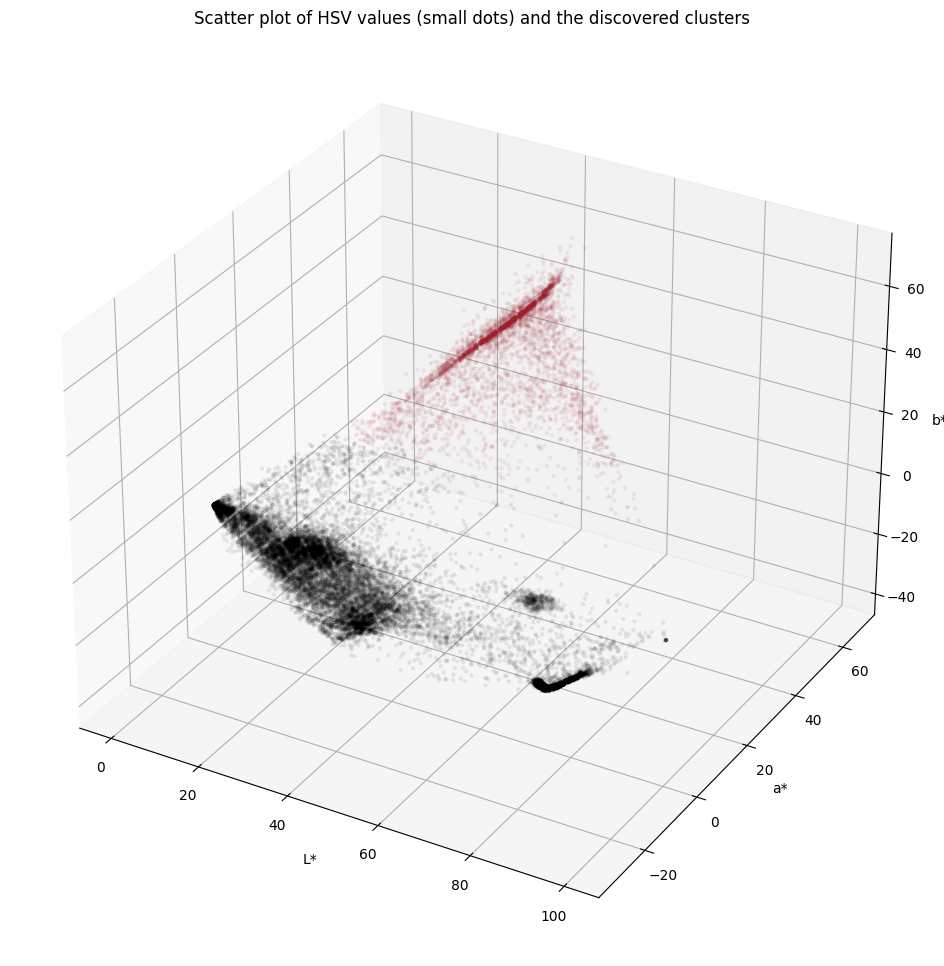

In [45]:
# Figure initialization
fig_size = 12
fig = plt.figure(figsize=(fig_size, fig_size))
ax = fig.add_subplot(111, projection="3d")

# Create scatter plot
seg_lab_val_plot = cv2.cvtColor(seg_lab_img.astype(np.float32), cv2.COLOR_LAB2RGB).reshape(-1, 3)
ax.scatter(img_lab_kmean.reshape(-1, 3)[::10, 0], img_lab_kmean.reshape(-1, 3)[::10, 1], 
  img_lab_kmean.reshape(-1, 3)[::10, 2], c=seg_lab_val_plot[::10], s=5, alpha=0.05)
# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
#   kmeans.cluster_centers_[:, 2], c=kmeans.cluster_centers_, s=75, marker="o", 
#   edgecolors=[(0, 0, 0)], alpha=1)

# labels and title
ax.set_xlabel("L*")
ax.set_ylabel("a*")
ax.set_zlabel("b*")
plt.title("Scatter plot of HSV values (small dots) and the discovered clusters")

plt.show()

Text(0.5, 1.0, 'LAB based K-Means Clustering')

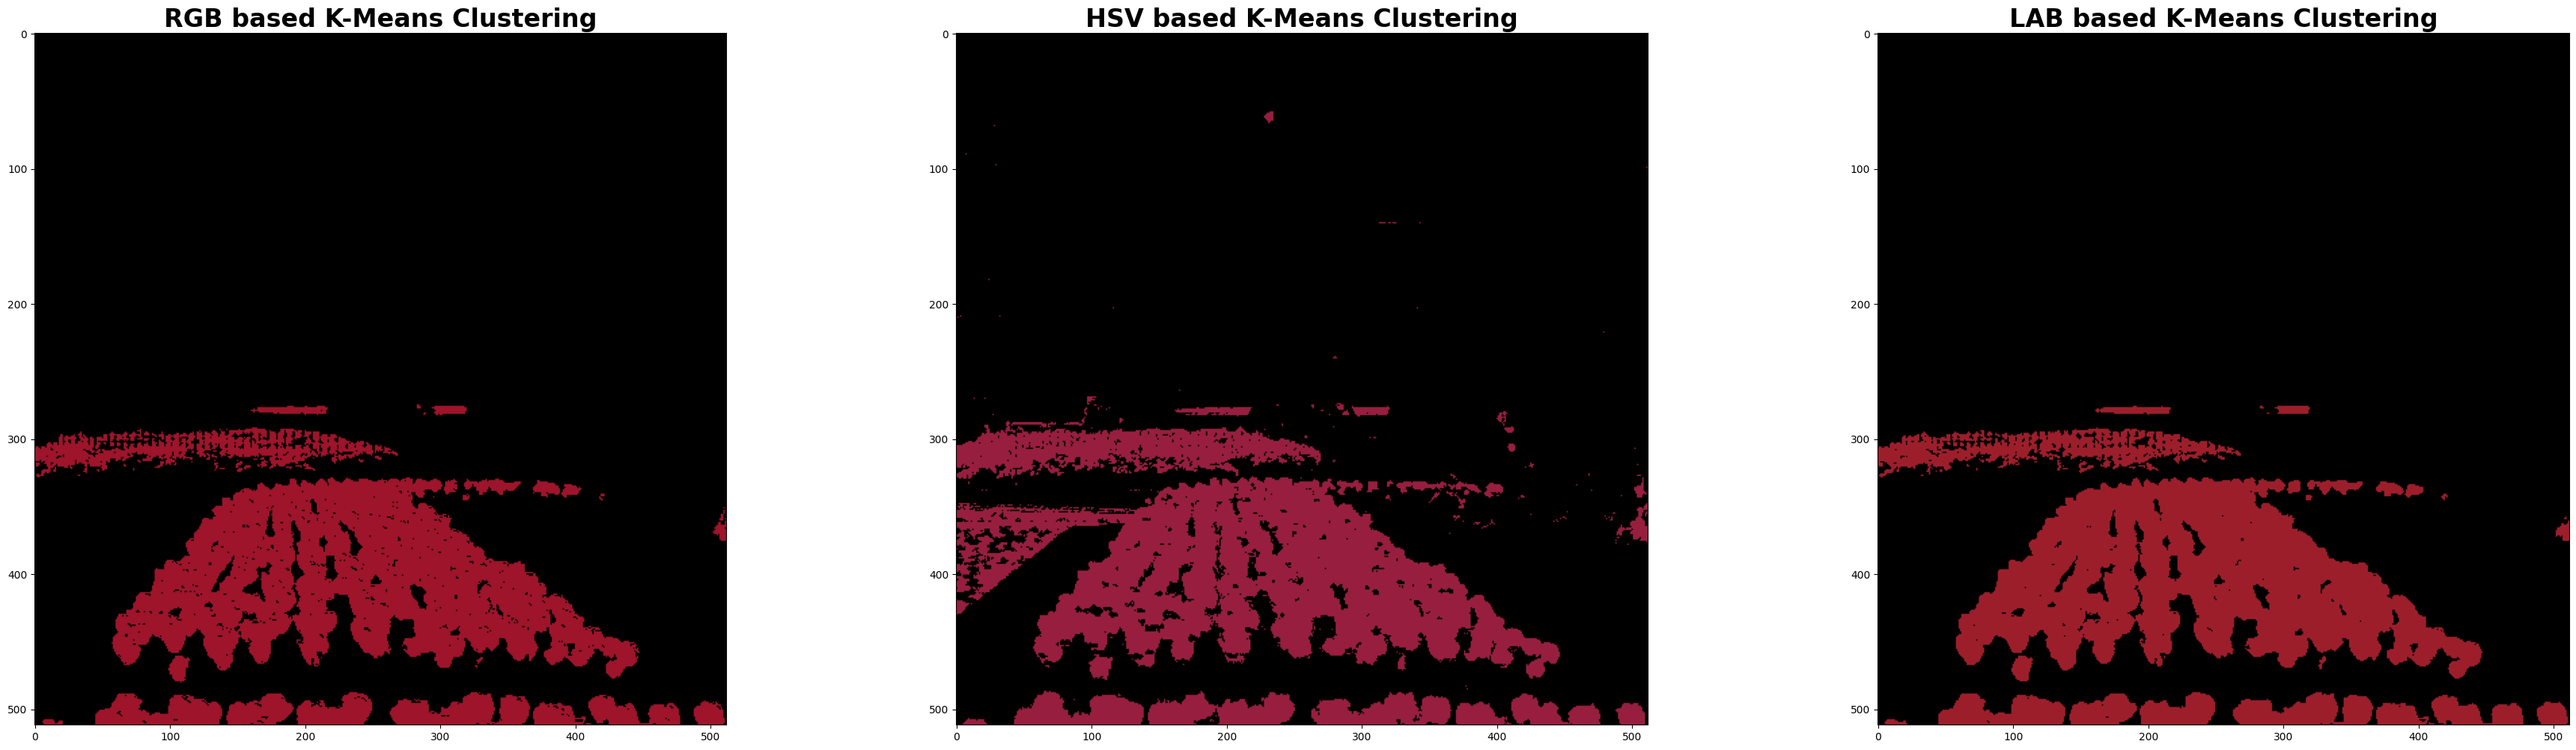

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [45, 12])

ax1.imshow(seg_rgb_img, cmap = 'gray')
ax1.set_title('RGB based K-Means Clustering', fontsize = 24, fontweight = 'bold')

ax2.imshow(cv2.cvtColor(seg_hsv_img.astype(np.float32), cv2.COLOR_HSV2RGB), cmap = 'gray')
ax2.set_title('HSV based K-Means Clustering', fontsize = 24, fontweight = 'bold')

ax3.imshow(cv2.cvtColor(seg_lab_img.astype(np.float32), cv2.COLOR_LAB2RGB), cmap = 'gray')
ax3.set_title('LAB based K-Means Clustering', fontsize = 24, fontweight = 'bold')

In [91]:
mIoU(cv2.cvtColor(seg_lab_img.astype(np.float32), cv2.COLOR_LAB2RGB), segmented_area)

0.8388079182075266

# **Task 3. Combination of clustering method and distance, and our own ideas**

<font size="5.5"> 
The approach for combination of clustering method and distance:
</font>

1. Reading the image using LAB color space
2. Using the K-Means clustering to cluster and segment the image to different classes
3. Get the cluster centers of the K-means clustering
4. Using the cluster centers and calculate the absolute distance between the image and the cluster centers
5. Using the array of absolute distance to segment the red flower

<font size="5.5"> 
Another ideas for color image segmentation using Mahalanobis distance:
</font>

1. Reading the image using the LAB color space
2. Using the mahalanobis distance to calculate the distance between original image to cropped image
3. Using the mahalanobis distance to segment the red flower

<font size="5.5"> 
Another approach for color image segmentation using maximum likelihood:
</font>

1. Reading the image using the LAB color space
2. Calculate the likelihood of cropped image in the original image using the maximum likelihood method
3. Assign the color with the highest likelihood

In [23]:
kmeans = KMeans(n_clusters = 3, n_init = 20)
kmeans.fit(img_lab_kmean.reshape(-1, 3))

idx = np.argmin(np.sum(abs(kmeans.cluster_centers_ - np.mean(img_crop_lab_kmean, axis = (0, 1))), axis = 1))
cluster_center = np.zeros(kmeans.cluster_centers_.shape)
cluster_center[idx] = kmeans.cluster_centers_[idx]

seg_lab_vals = cluster_center[kmeans.labels_]

seg_lab_img = seg_lab_vals.reshape(img_lab_kmean.shape)

100%|██████████| 20/20 [00:01<00:00, 17.97it/s]

[[0.65714717 0.8168355  0.8624469 ]
 [0.6200942  0.07853065 0.16825989]
 [0.17950563 0.26904276 0.24851467]]


In [26]:
np.cov(img_rgb_crop.reshape(-1, 3), rowvar=False)

array([[678.39461048, 549.50227483, 485.87676602],
       [549.50227483, 910.5412686 , 786.07504926],
       [485.87676602, 786.07504926, 699.07572321]])

In [44]:
def mahalanobis_dist(x, train_rgb):
    mu = np.mean(train_rgb, axis = (0, 1))
    cov = np.cov(train_rgb, rowvar=False)
    temp = x - mu
    mahalanobis = np.dot(np.dot(temp, np.linalg.inv(cov)), temp)
    return mahalanobis ** 0.5

In [7]:
def maximum_likelihood(x, train_rgb, d, prob):
    mu = np.mean(train_rgb, axis = 0)
    covariance = np.cov(train_rgb, rowvar = False)
    temp = x - mu
    gx = -0.5 * np.dot(np.dot(temp, np.linalg.inv(covariance)), temp) - d/2 * np.log(2 * np.pi) - 1/2 * np.log(np.linalg.det(covariance)) + np.log(prob)
    return gx